In [1]:
options(repr.plot.width  = 15, repr.plot.height = 10)

In [2]:
#install.packages("ranger")

# Libraries

In [3]:
# Helper packages
library(dplyr)    # for data wrangling
library(ggplot2)  # for awesome graphics

# Modeling packages
library(caret)
library(ranger)   # a c++ implementation of random forest 



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice



# Random Forest 
Random Forest extiende la idea de bagging usando árboles de decisión incluyendo una selección aleatoria de features para cada árbol con el fin de reducir la correlación entre árboles. Este parámetro es conocido como $m_{try}$ y generalmente para problemas de regresión se usa $m_{try} = \frac{p}{3}$ y para clasificación $m_{try} = \sqrt{p}$ siendo $p$ el número total de features. Sin embargo este es uno de los parámetros a ajustar para obtener el mejor modelo.

## Pseudocódigo
* Data un dataset de entrenamiento
* Seleccionar el número de árboles a construir (n_trees)
* Desde k = 0 hasta n_trees   
      Generar una muestra usando bootstrapping del dataset de entrenamiento
      Entrenar el árbol k con la muestra anterior
      Para cada split hacer:
          Seleccionar $m_{try}$ features aleatoriamente del total de features
          Seleccionar la feature/threshold que que logre reducir más el error en el split
          Dividir el nodo en 2
      fin
      Usar alguno de los criterios para para de hacer split
  fin
* Retornar el ensamble



# Load Data

In [59]:
ames <- AmesHousing::make_ames()

# Split Dataset

In [60]:
set.seed(123)
index_train <- createDataPartition(ames$Sale_Price, p = 0.8, 
                               list = FALSE, )
index_train  <- as.vector(index_train)

house_train <- ames[index_train, ]
house_test  <- ames[-index_train, ]

# Modeling
## Ranger
Random Forest tiene varias librerías que lo implementan con diferentes enfoques, uno de ellos es   `randomForest` que es más clásico y `ranger` que es una implementación en c++ que es mucho más eficiente el cual estaremos usando ahora.

Por defecto `ranger` tiene por defecto $m_{try} = \sqrt{p}$ pero para problemas de regresion se recomienda partar con $\frac{p}{3}$ y fijar el parametro `respect.unordered.factors = "order"` esto para que trate las variables categoricas sin orden las trate como ordenas segun el target (al igual que implementa rpart)

In [61]:
# number of features
n_features <- length(setdiff(names(house_train), "Sale_Price"))

# train a default random forest model
house_rf1 <- ranger(
  Sale_Price ~ ., 
  data = house_train,
  seed = 123
)

# get OOB RMSE
default_rmse <- sqrt(house_rf1$prediction.error)
default_rmse

[1] 25630.04

In [62]:
# Numero de arboles
house_rf1$num.trees

[1] 500

In [63]:
# numero de features
house_rf1$num.independent.variables

[1] 80

In [64]:
# Numero de feautes a considerar en cada split
house_rf1$mtry

[1] 8

In [65]:
# Minimo numero de observaciones en una hoja
house_rf1$min.node.size

[1] 5

In [66]:
house_rf1$splitrule

[1] "variance"

In [67]:
house_rf1$treetype

[1] "Regression"

### Predictions
en ranger la función predict no retorna directamente los valores, en lugar de ello retorna un objeto `ranger.prediction`.

Para obtener los valores tenemos que usar predict(...)$predictions


In [68]:
class(predict(house_rf1, house_train))

[1] "ranger.prediction"

In [69]:
RMSE(pred = predict(house_rf1, house_train)$predictions,
     obs = house_train$Sale_Price)

[1] 11356.64

In [70]:
RMSE(pred = predict(house_rf1, house_test)$predictions,
     obs = house_test$Sale_Price)

[1] 25758.22

## Version Custom
Acá se muestran varios de los valores que podemos modificar para obtener el mejor modelo. Podemos variar manualmente cada uno de ellos y ver el efecto en el performance.

In [71]:
house_rfc <- ranger(
  Sale_Price ~ ., 
  data = house_train,
  num.trees = 500,
  mtry = floor(n_features / 3),
  #min.node.size = 5,
  #max.depth = 0,
  #replace=TRUE,
  #respect.unordered.factors = "order",
  oob.error = TRUE,
  seed = 123
)

# get OOB RMSE
sqrt(house_rfc$prediction.error)

[1] 24940.67

In [72]:
house_rfc$mtry

[1] 26

## Error para diferentes #árboles

In [73]:

seq(10, 500, 10)

[1]  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180 190
[20] 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380
[39] 390 400 410 420 430 440 450 460 470 480 490 500

In [74]:
n_trees = seq(10, 500, 10)
params = data.frame(n_trees = n_trees,
                    oob = rep(0, length(n_trees)))

for (k in 1:nrow(params)) {
    house_rfk <- ranger(
      Sale_Price ~ ., 
      data = house_train,
      num.trees = params[k, "n_trees"],
      respect.unordered.factors = "order",
      oob.error = TRUE,
      seed = 123
    )

    # get OOB RMSE
    params[k, "oob"]<- sqrt(house_rfk$prediction.error)
    
}


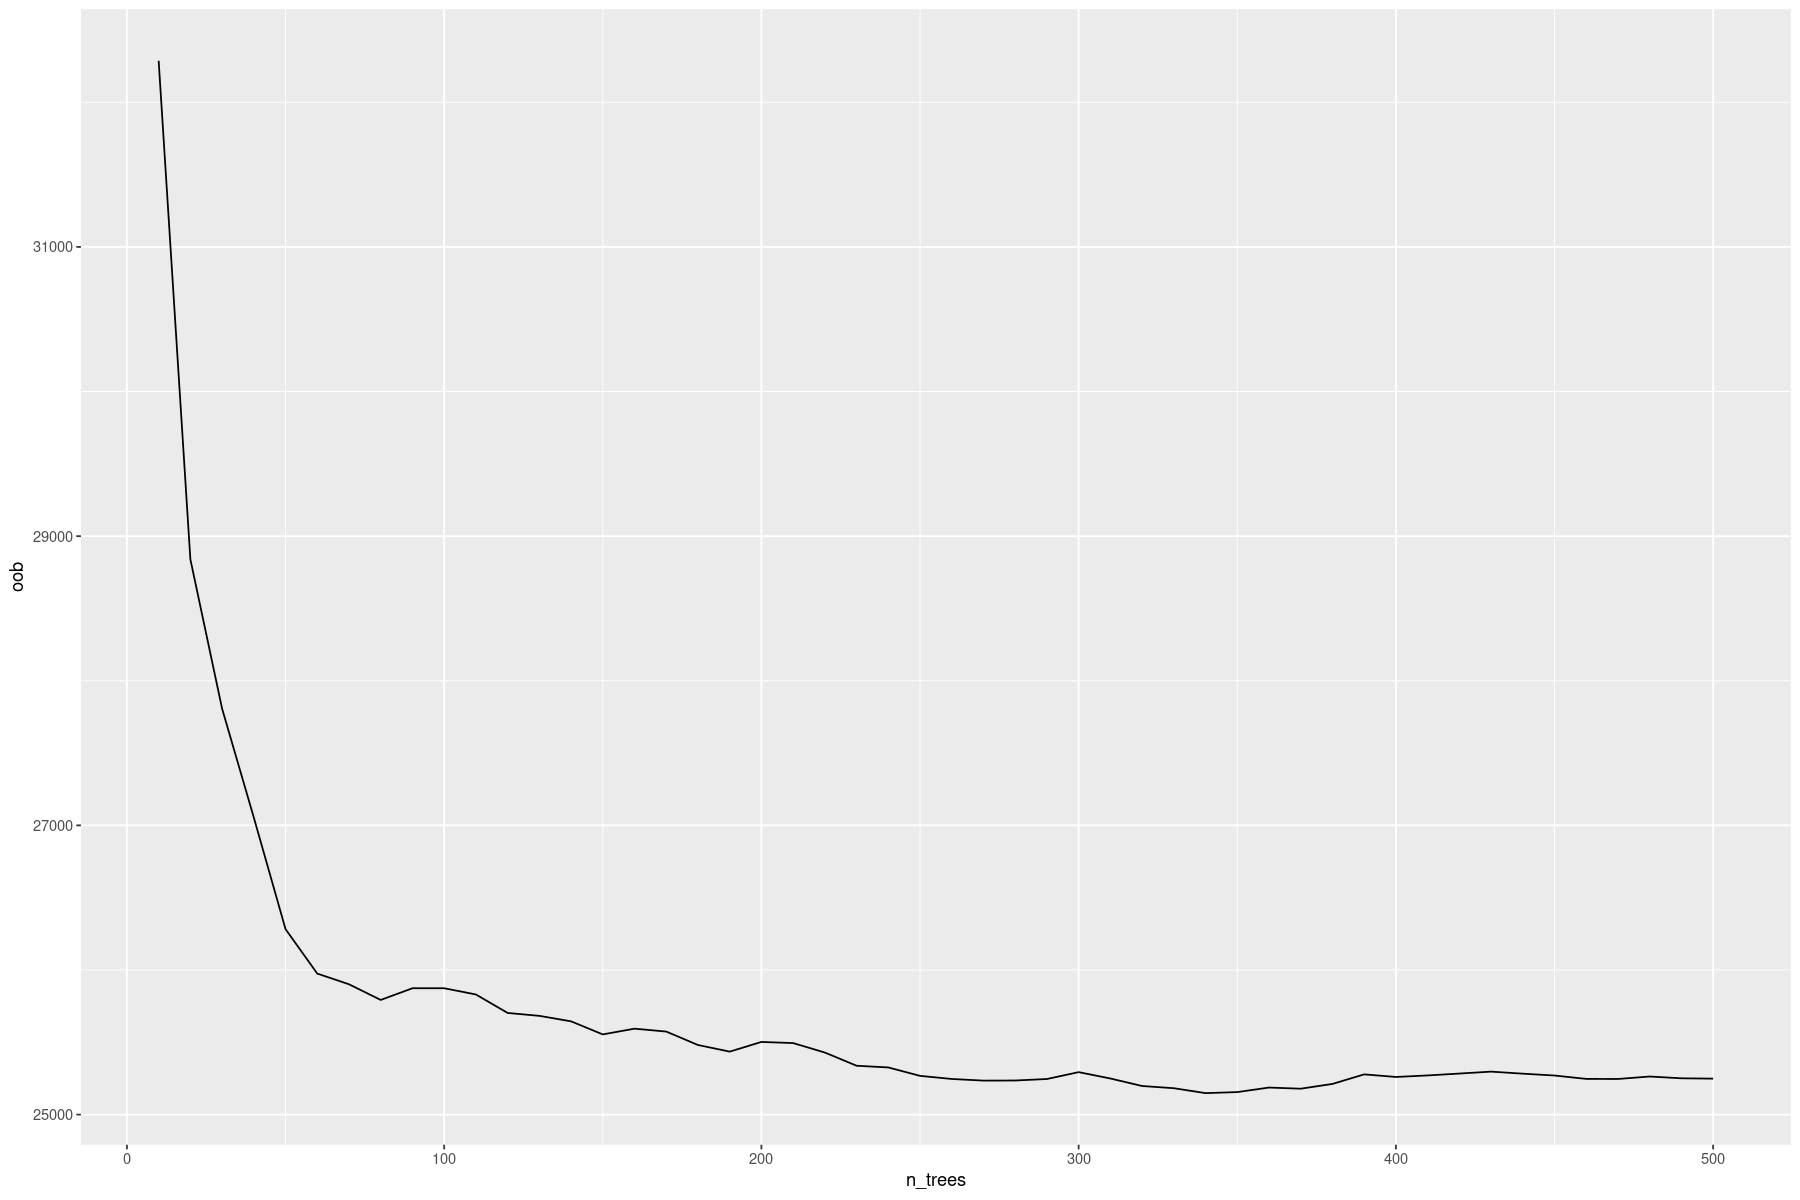

In [75]:
ggplot(params, aes(x=n_trees, y=oob)) +
    geom_line()

In [76]:
params

n_trees,oob
<dbl>,<dbl>
10,32287.35
20,28839.75
30,27807.23
40,27054.25
50,26282.34
60,25974.94
70,25901.08
80,25792.85
90,25873.79


## Tuning
A pesar de que RF tiene un buen resultado con los valores por defecto en OOB, hay un conjunto de hiper-parámetros que podemos controlar para llegar al mejor resultado para nuestro dataset.

1. Número de árboles (estimadores)
2. Número de features a considerar en cada split: mtry
3. La complejidad de cada árbol
4. La técnica de muestreo
5. La regla de splitting en la fase de construcción del árbol

* En general (2) tiene un alto impacto en el performance del modelo y debe ser ajustado
* (3) y (4) suele tener una contribución marginal en el performance pero vale la pena explorarlo
* (5) suele tener una contribución marginal en el performance pero puede afectar en la eficiencia computacional




### Numero de arboles
El numero de arboles tiene que ser lo suficientemente grande como para estabilizar la tasa de error. Modificando otro hiper-parámetros como mtry o node_size, el número de árboles podría variar para lograr estabilizar el error.

Más árboles más estable pero también más costoso computacionalmente.



### $ m_{try}$
Controla el número de variables a considerar en cada split, si este número es igual al número de features entonces se logra el mismo resultado que bagging.
* Más pequeño el número menos correlacionado estará los árboles pero también menos chance de obtener variables importantes a la hora de construir el árbol
* Por defecto regresión = $\frac{p}{3}$, clasificación = $\sqrt{p}$
* Si hay pocas variables relevantes entonces un valor alto de $m_{try}$ obtiene mejores resultados, al contrario si tenemos varias variables relevantes este número tiene a ser más pequeño.

###  Tree complexity
Son los hiper-parámetros propios de los árboles que nos permiten controlar la complejidad de estos.
* tamaño del nodo (número de observaciones en las hojas)
* max profundidad
* el mínimo número de observaciones en un nodo para hacer un split

Si el dataset es muy ruidoso, controlar la complejidad puede ayudar a mejorar la performance.

### Técnica de muestreo
Por defecto random forest use bootstrapping como técnica de muestreo, sin embargo podríamos no hacer esto y simplemente hacer un muestreo aleatorio y controlar el tamaño de la partición (train/val).
* Disminuir el tamaño de la partición ayuda a tener árboles más diversos disminuyendo la correlación entre árboles.
* Además si tiene features categóricas con un gran número de niveles y no son balanceadas bootstrapping podría sesgar los resultados y realizar un muestreo aleatorio podría ayudar a mejorar el resultado.

### Split rule
En el caso de clasificación el criterio para buscar la mejor feature/threshold es gini/entropy y para regresión SSE. Sin embargo hay otros posibles métodos 
* Conditional inference trees
* Extremely randomized trees

## Tuning strategies
Con modelos mas complejos (flexibles) incremente el numero de posibles hiper-parametros a tener en cuenta, para ello se hace necesario tener una estrategia para no probar una por una las combinaciones de ellos.
* Grid Search
* Random Search

Ahora vamos probar con Grid Search



In [77]:
expand.grid(num=c(1,2,3), cat = c('a', 'b'))

num,cat
<dbl>,<fct>
1,a
2,a
3,a
1,b
2,b
3,b


In [78]:
# create hyperparameter grid
hyper_grid <- expand.grid(
  mtry = floor(n_features * c(.05, .15, .25, .333, .4)),
  n_trees = c(200, 500, 1000, 2000),
  min.node.size = c(1, 3, 5, 10), 
  replace = c(TRUE, FALSE),                               
  sample.fraction = c(.5, .63, .8),                       
  rmse = NA                                               
)

# execute full cartesian grid search
for(i in seq_len(nrow(hyper_grid))) {
  # fit model for ith hyperparameter combination
  fit <- ranger(
    formula         = Sale_Price ~ ., 
    data            = house_train, 
    num.trees       = hyper_grid$n_trees[i],
    mtry            = hyper_grid$mtry[i],
    min.node.size   = hyper_grid$min.node.size[i],
    replace         = hyper_grid$replace[i],
    sample.fraction = hyper_grid$sample.fraction[i],
    verbose         = FALSE,
    seed            = 123,
    respect.unordered.factors = 'order',
  )
  # export OOB error 
  hyper_grid$rmse[i] <- sqrt(fit$prediction.error)
}

# assess top 10 models
hyper_grid %>%
  arrange(rmse) %>%
  mutate(perc_gain = (default_rmse - rmse) / default_rmse * 100) %>%
  head(10)

,mtry,n_trees,min.node.size,replace,sample.fraction,rmse,perc_gain
,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
1,32,2000,1,FALSE,0.8,23702.67,7.519989
2,12,1000,1,FALSE,0.8,23712.69,7.480869
3,32,500,3,FALSE,0.8,23715.12,7.471387
4,12,2000,1,FALSE,0.8,23724.21,7.435925
5,26,2000,1,FALSE,0.8,23729.03,7.417138
6,20,2000,1,FALSE,0.8,23733.08,7.401309
7,32,2000,3,FALSE,0.8,23736.04,7.389756
8,26,1000,1,FALSE,0.8,23771.90,7.249862
9,12,500,1,FALSE,0.8,23783.23,7.205671


## Feature interpretation
* impurity-based
* permutation-based


In [79]:
n_trees = 200
m_try = 32
min_node_size = 1
sample_fraction = .8
replace = FALSE
ord_factors = "order"

# impurity-based variable importance
rf_impurity <- ranger(
  formula = Sale_Price ~ ., 
  data = house_train, 
  num.trees = n_trees,
  mtry = m_try,
  min.node.size = min_node_size,
  sample.fraction = sample_fraction,
  replace = replace,
  importance = "impurity",
  respect.unordered.factors = ord_factors,
  verbose = FALSE,
  seed  = 123
)

# permutation-based variable importance
rf_permutation <- ranger(
  formula = Sale_Price ~ ., 
  data = house_train, 
  num.trees = n_trees,
  mtry = m_try,
  min.node.size = min_node_size,
  sample.fraction = sample_fraction,
  replace = replace,
  importance = "permutation",
  respect.unordered.factors = ord_factors,
  verbose = FALSE,
  seed  = 123
)

En la gráfica de la importancia de las variables se puede notar algunas diferencias en el orden de las variables, pero en general las de más arriba y las de más abajo se mantiene más o menos constante. En este ejemplo se puede decir que al menos esta features son relevantes para el problema:

* Overall_Qual
* Gr_Liv_Area
* Neighborhood

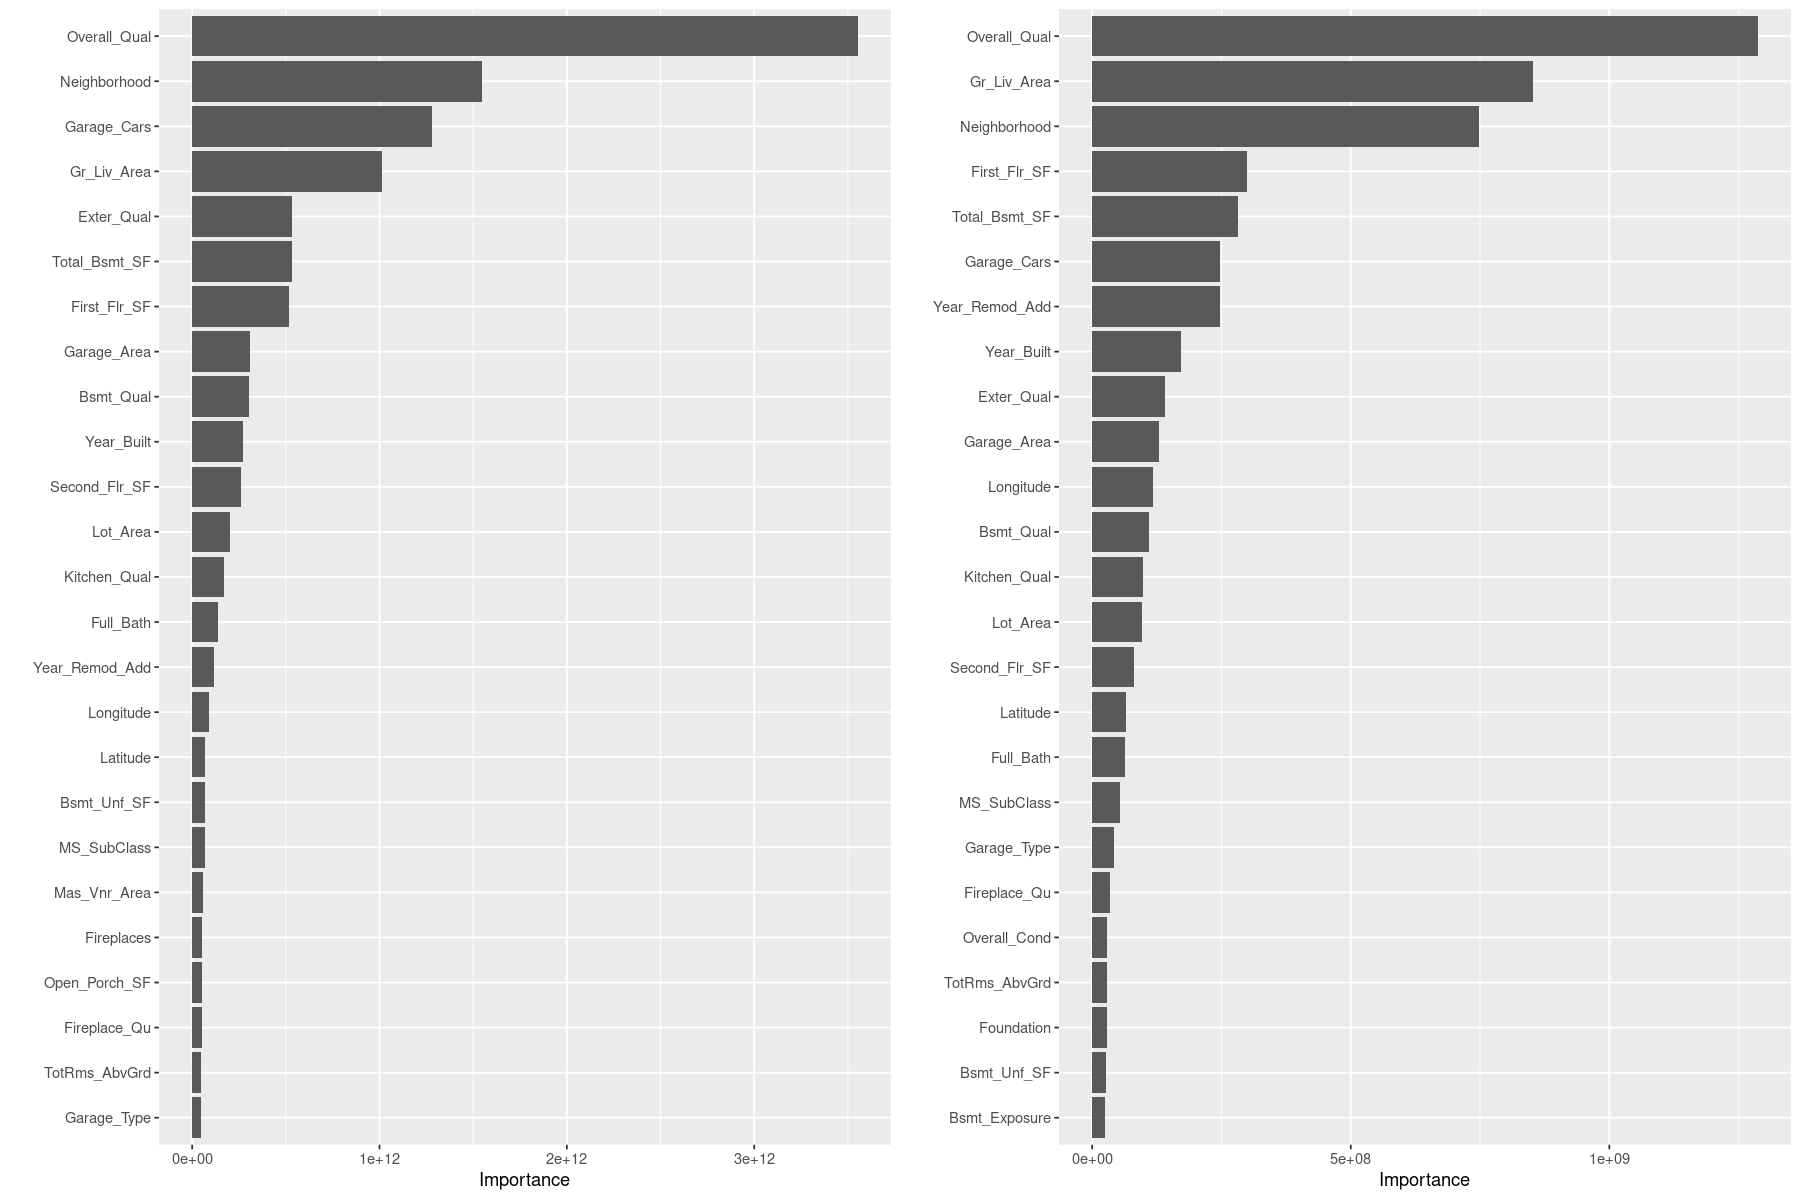

In [80]:
p1 <- vip::vip(rf_impurity, num_features = 25)
p2 <- vip::vip(rf_permutation, num_features = 25 )

gridExtra::grid.arrange(p1, p2, nrow = 1)

# Challenge
Usa el dataset de las propiedades a la venta en montevideo para predecir el valor de venta.

Variable a predecir **price**

In [4]:
prorperties_uri = 'https://raw.githubusercontent.com/creyesp/Meetup_uy/master/data/ready/properties.csv'

In [5]:
df_raw <- read.csv(prorperties_uri)

In [6]:
head(df_raw)

,year,bathrooms,bedrooms,garage,servide_fees,surface_balcony,surface_covered,floor_special,floor,price,facilities,near_river,m2_index,is_house,barbecue,decade,zone,orientation,state
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<int>,<fct>,<int>,<fct>,<fct>,<fct>
1,2016,2,2,1,12500,13,84,0,1,325000,0,False,1,0,True,2010,carrasco,F,FR
2,1950,3,4,2,0,0,551,0,1,1100000,0,False,1,1,False,1950,carrasco norte,,GE
3,1950,3,3,2,0,0,142,0,1,440000,0,False,1,0,False,1950,carrasco,,GE
4,2000,3,4,2,38000,0,290,0,3,800000,0,False,1,0,True,2000,puerto buceo,F,EE
5,1950,3,3,2,31000,0,270,0,1,600000,0,False,1,0,False,1950,la caleta,,GE
6,1965,2,3,0,7500,0,93,0,1,98000,0,True,1,0,False,1960,centro,F,GE


In [7]:
data.frame(missing = sapply(df_raw, function (x) {sum(is.na(x))}))

,missing
,<int>
year,0
bathrooms,0
bedrooms,0
garage,0
servide_fees,0
surface_balcony,0
surface_covered,0
floor_special,0
floor,0


In [8]:
df <- df_raw %>% 
    select(-all_of('year'))

head(df)

,bathrooms,bedrooms,garage,servide_fees,surface_balcony,surface_covered,floor_special,floor,price,facilities,near_river,m2_index,is_house,barbecue,decade,zone,orientation,state
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<int>,<fct>,<int>,<fct>,<fct>,<fct>
1,2,2,1,12500,13,84,0,1,325000,0,False,1,0,True,2010,carrasco,F,FR
2,3,4,2,0,0,551,0,1,1100000,0,False,1,1,False,1950,carrasco norte,,GE
3,3,3,2,0,0,142,0,1,440000,0,False,1,0,False,1950,carrasco,,GE
4,3,4,2,38000,0,290,0,3,800000,0,False,1,0,True,2000,puerto buceo,F,EE
5,3,3,2,31000,0,270,0,1,600000,0,False,1,0,False,1950,la caleta,,GE
6,2,3,0,7500,0,93,0,1,98000,0,True,1,0,False,1960,centro,F,GE


In [9]:
set.seed(123)
index_train_df <- createDataPartition(df$price, p = 0.8, 
                               list = FALSE, )
index_train_df  <- as.vector(index_train_df)

df_train <- df[index_train_df, ]
df_test  <- df[-index_train_df, ]

## Modeling

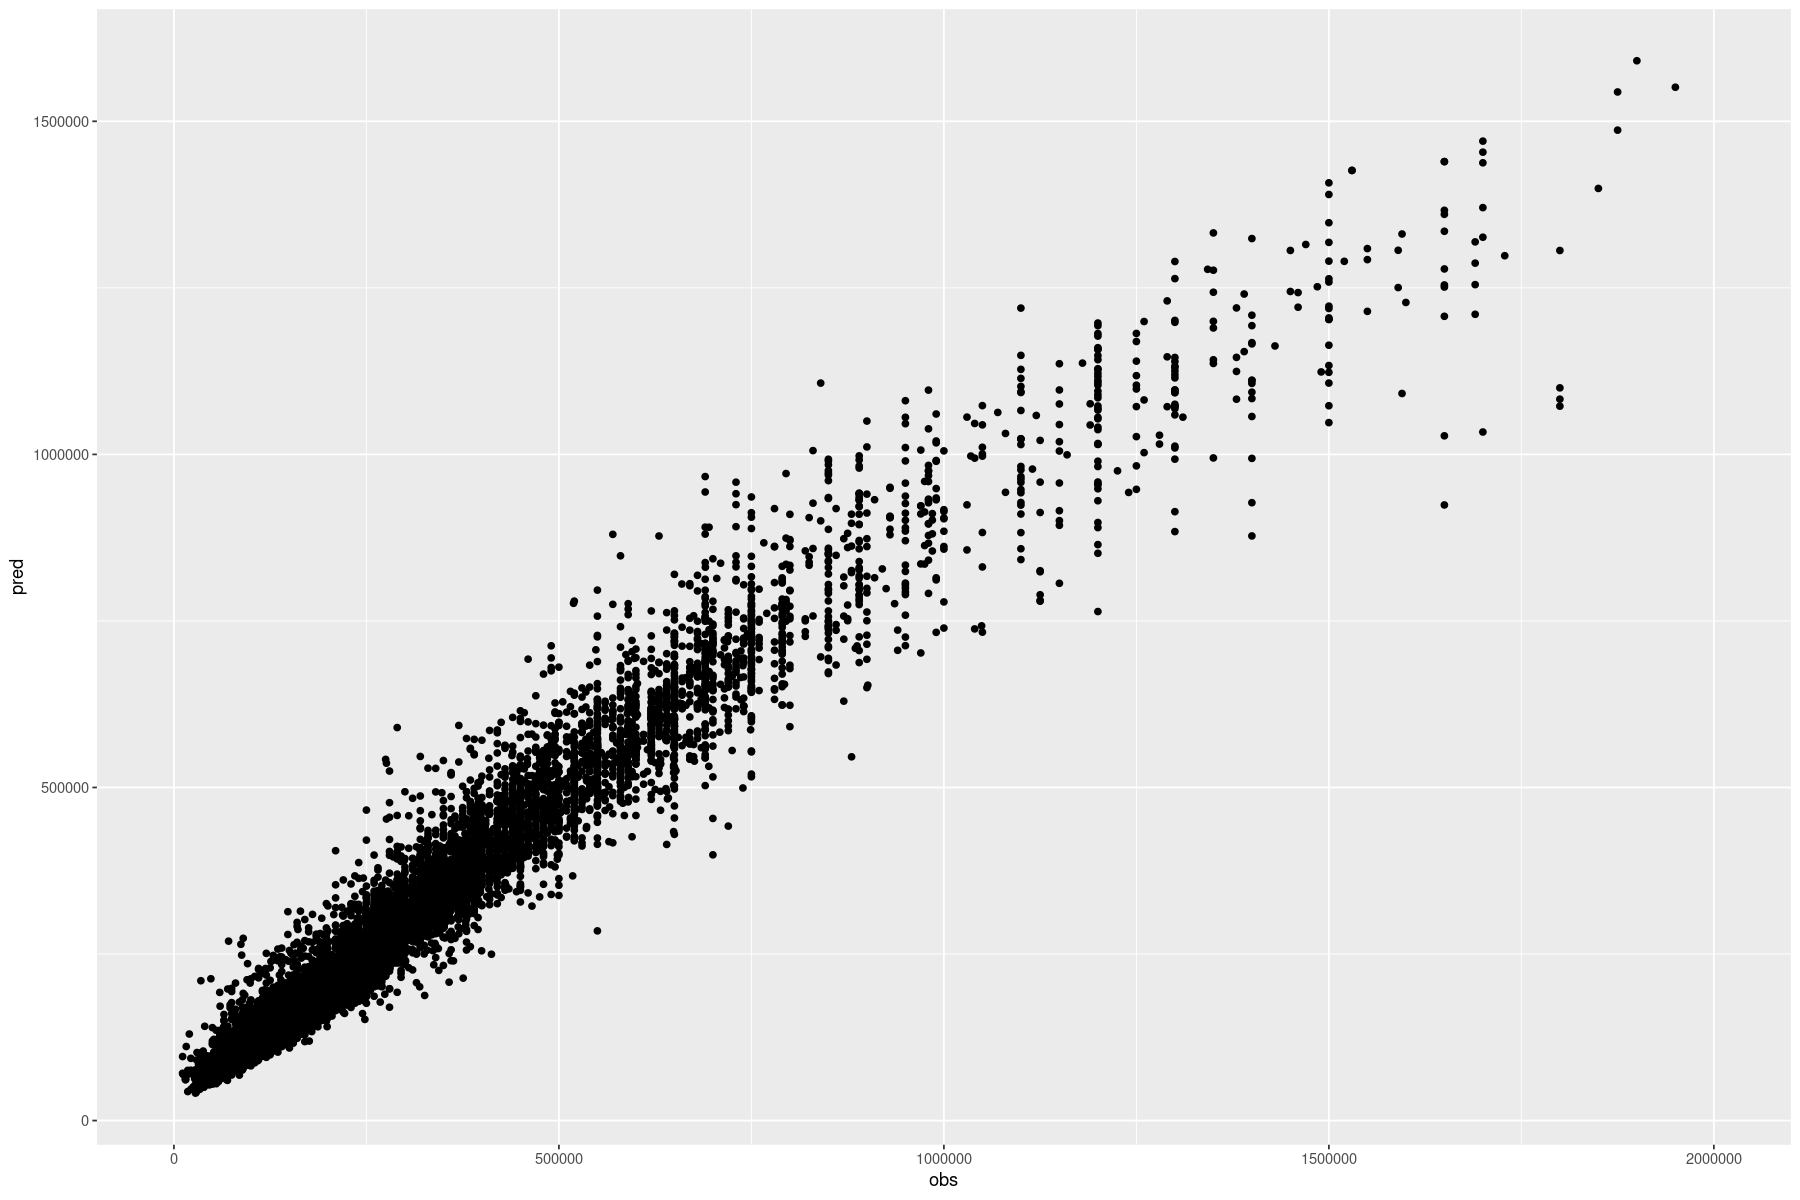

In [10]:
mvd_rf <- ranger(
  price ~ ., 
  data = df_train,
  num.trees = 100,
  #mtry = floor(79 / 3),
  #min.node.size = 5,
  #max.depth = 0,
  #replace=TRUE,
  #respect.unordered.factors = "order",
  oob.error = TRUE,
  seed = 123
)

# get OOB RMSE
result = data.frame(pred = predict(mvd_rf, df_train)$predictions,
                    obs = df_train$price) 
ggplot(result, aes(x=obs, y=pred)) + 
    geom_point() + 
    xlim(0, 2e6)


## Testing

In [11]:
names(df_train)

[1] "bathrooms"       "bedrooms"        "garage"          "servide_fees"   
 [5] "surface_balcony" "surface_covered" "floor_special"   "floor"          
 [9] "price"           "facilities"      "near_river"      "m2_index"       
[13] "is_house"        "barbecue"        "decade"          "zone"           
[17] "orientation"     "state"

In [15]:
test1 <- data.frame(
    bathrooms=2,
    bedrooms=1,
    garage=0,
    servide_fees=2000,
    surface_balcony=10,
    surface_covered=80,
    floor_special=0,
    floor=1,
    #price=0,
    facilities=FALSE,
    near_river=TRUE,
    m2_index=1,
    is_house=0,
    barbecue=1,
    decade=2000,
    zone='pocitos',
    orientation='F',
    state='EE'
)
round(predict(mvd_rf, test1)$predictions)

[1] 164947

In [16]:
test1 <- data.frame(
    bathrooms=3,
    bedrooms=1,
    garage=0,
    servide_fees=2000,
    surface_balcony=10,
    surface_covered=80,
    floor_special=0,
    floor=1,
    #price=0,
    facilities=FALSE,
    near_river=TRUE,
    m2_index=1,
    is_house=0,
    barbecue=1,
    decade=2000,
    zone='pocitos',
    orientation='F',
    state='EE'
)
round(predict(mvd_rf, test1)$predictions)

[1] 332038

In [17]:
test1 <- data.frame(
    bathrooms=4,
    bedrooms=1,
    garage=0,
    servide_fees=2000,
    surface_balcony=10,
    surface_covered=80,
    floor_special=0,
    floor=1,
    #price=0,
    facilities=FALSE,
    near_river=TRUE,
    m2_index=1,
    is_house=0,
    barbecue=1,
    decade=2000,
    zone='pocitos',
    orientation='F',
    state='EE'
)
round(predict(mvd_rf, test1)$predictions)

[1] 332038

In [18]:
test1 <- data.frame(
    bathrooms=5,
    bedrooms=1,
    garage=0,
    servide_fees=2000,
    surface_balcony=10,
    surface_covered=80,
    floor_special=0,
    floor=1,
    #price=0,
    facilities=FALSE,
    near_river=TRUE,
    m2_index=1,
    is_house=0,
    barbecue=1,
    decade=2000,
    zone='pocitos',
    orientation='F',
    state='EE'
)
round(predict(mvd_rf, test1)$predictions)

[1] 332038

In [13]:
test1

bathrooms,bedrooms,garage,servide_fees,surface_balcony,surface_covered,floor_special,floor,facilities,near_river,m2_index,is_house,barbecue,decade,zone,orientation,state
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
2,1,0,2000,10,200,0,1,FALSE,TRUE,1,0,1,2000,pocitos,F,EE
